In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, os
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

## MetaData

In [3]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
COLLECTION = 'ailey-dev'
EXPERIMENT = "170726_Insula-vCapture-Atenolol2_00-56-01"
CHANNEL = "Ch1"
RES = 3
x_range = [0, 2160]
y_range = [0, 2560]
z_range = [0, 1425]
resolution = 3
SAVE_DIR = '../Data/Insula/'
INTERN_CFG_DIR = './intern.cfg'

In [4]:
def get_img(col, exp, ch, res=3, intern_cfg = './intern.cfg'):
    rmt = BossRemote(cfg_file_or_dict=intern_cfg)
    return rmt, ndreg.download_image(rmt, col, exp, ch, res=res)

# Download brain volume and atlas

In [8]:
rmt, img = get_img(COLLECTION, EXPERIMENT, CHANNEL)
atlas = ndreg.download_ara(rmt, 50)

# Preprocessing

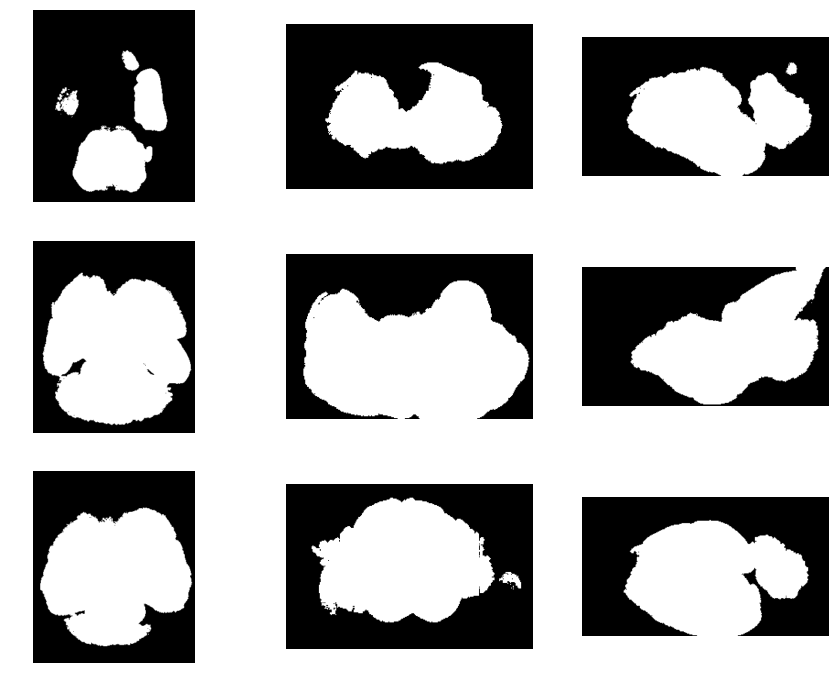

In [9]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)
ndreg.imgShow(mask_sitk, vmax=1)

In [10]:
# new
img_bc = preprocessor.correct_bias_field(img, scale=0.25, mask=mask_sitk,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 100, 50])

In [ ]:
# old
img_bc = preprocessor.correct_bias_field(img, scale=1.0,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 200, 50])
ndreg.imgShow(img_bc, vmax=2500)

[13.209600000000002, 8.0, 11.4]


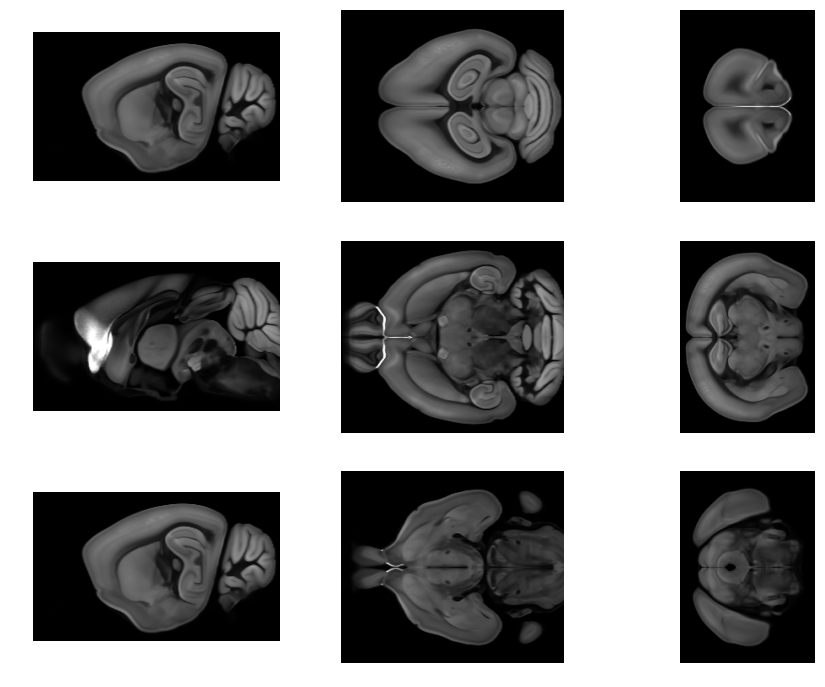

In [11]:
img_bc_ds = sitk.Normalize(atlas)
atlas_ds = sitk.Normalize(img_bc)
# atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(img_bc_ds, atlas_ds, "pir", "lps", 0.05, default_value=ndreg.imgPercentile(img_bc_ds, 0.01))
atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(img_bc_ds, atlas_ds, "pir", "lps", 0.05, ndreg.imgPercentile(img_bc_ds, 0.01))

ndreg.imgShow(atlas_ds)

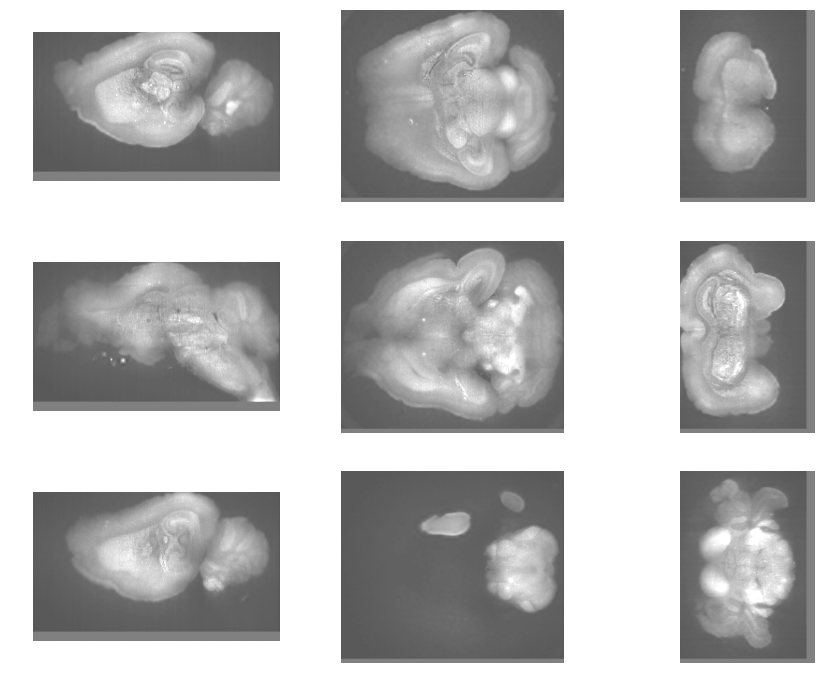

In [12]:
ndreg.imgShow(img_bc_ds, vmax=3, vmin=-3)

# Affine registration

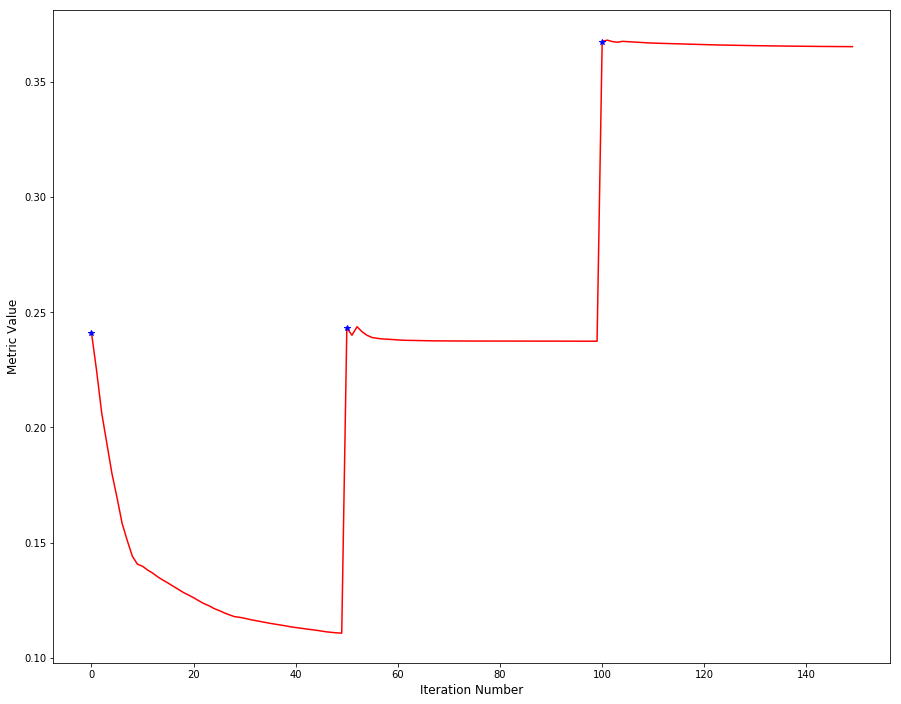

In [13]:
final_transform = registerer.register_affine(atlas_ds,
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

In [14]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

In [15]:
img = sitk.GetArrayFromImage(out_atlas)

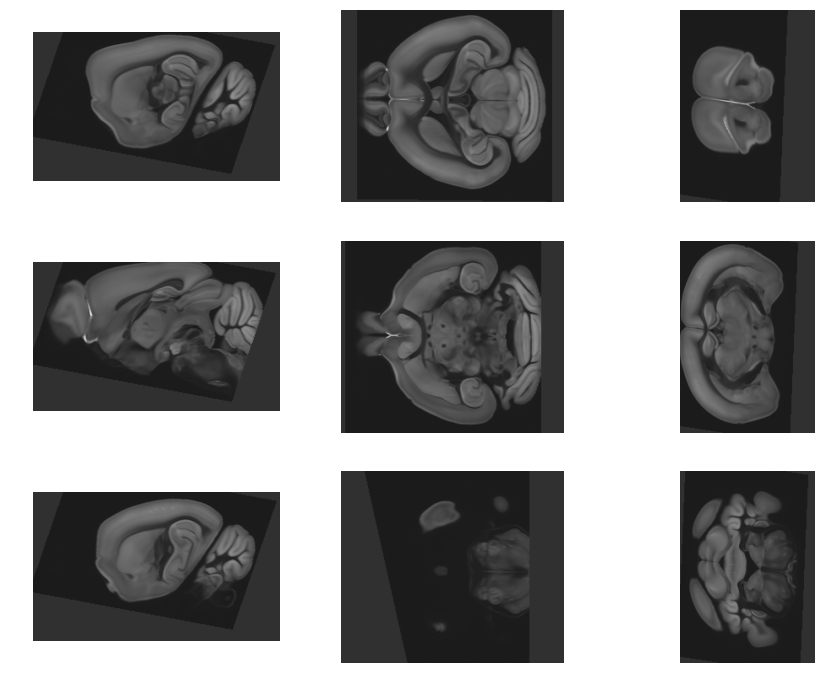

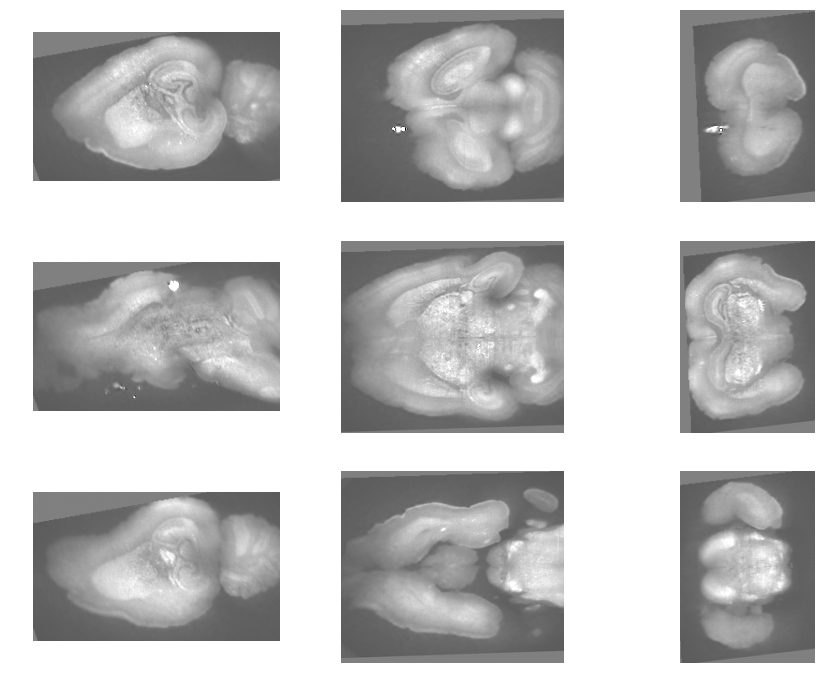

In [16]:
ndreg.imgShow(out_atlas)
ndreg.imgShow(out_target, vmax=3, vmin=-3)

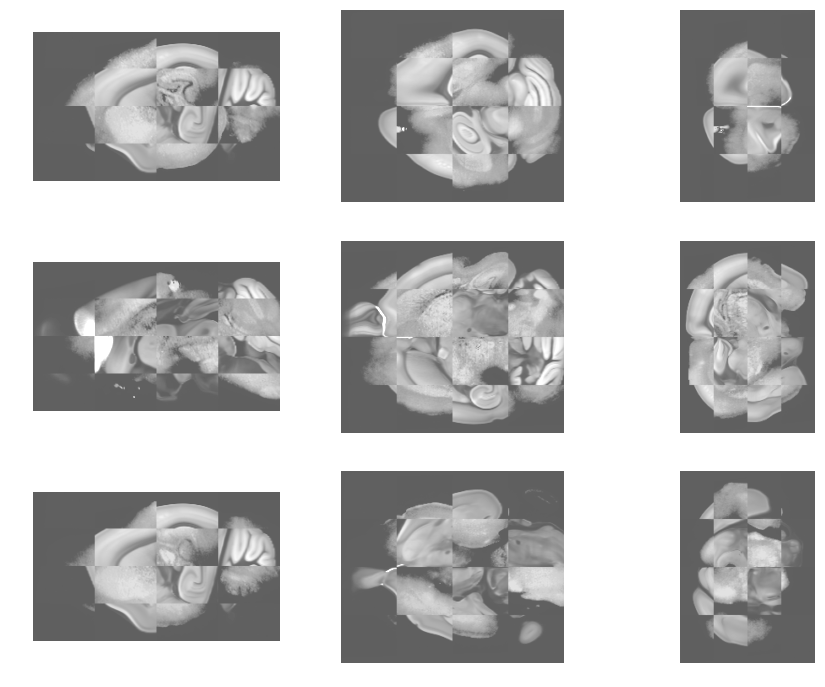

In [17]:
ndreg.imgShow(ndreg.imgChecker(out_target, sitk.Normalize(atlas)), vmax=3, vmin=-3)

# LDDMM registration

In [18]:
WHITEN_RADIUS = [5,5,5]
ALPHA = 0.25
BETA = 0.25

In [19]:
out_target_whitened = preprocessor.whiten(out_target, radius=WHITEN_RADIUS, alpha=ALPHA, beta=BETA)

In [20]:
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=WHITEN_RADIUS)

In [21]:
out_atlas_whitened = preprocessor.whiten(out_atlas, radius=WHITEN_RADIUS)
img_bc_ds_whitened = preprocessor.whiten(img_bc_ds, radius=WHITEN_RADIUS)

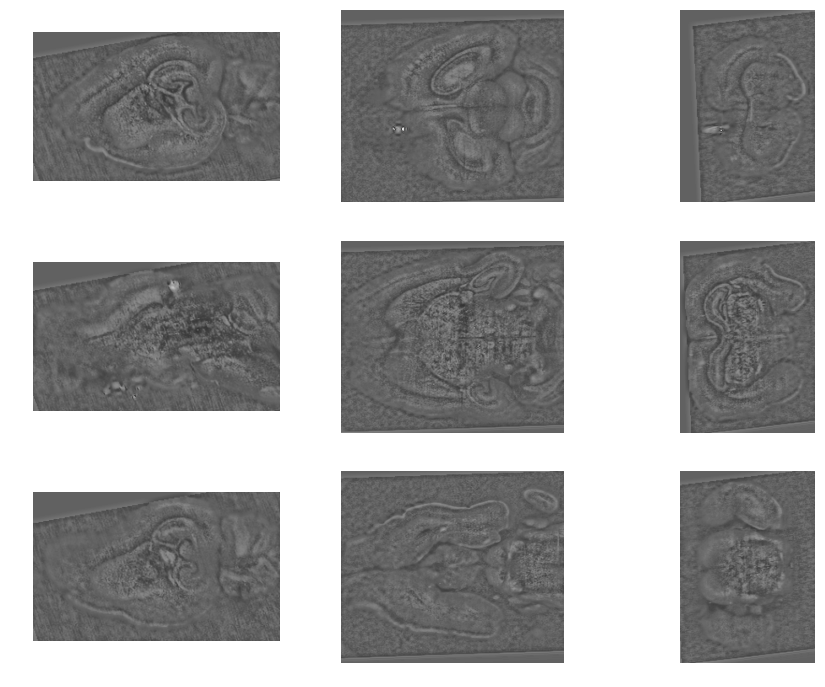

In [22]:
ndreg.imgShow(out_target_whitened)

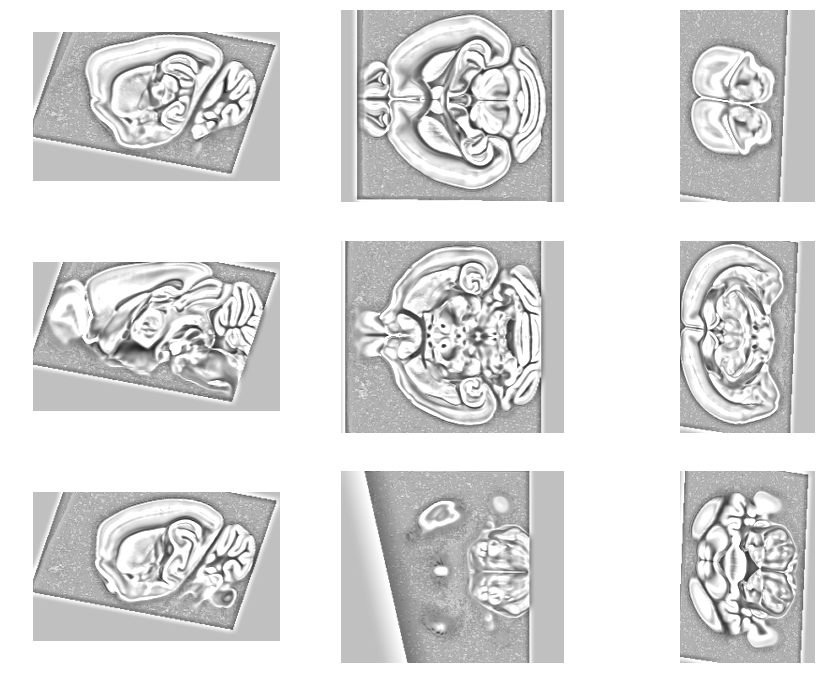

In [23]:
ndreg.imgShow(out_atlas_whitened, vmax=3)

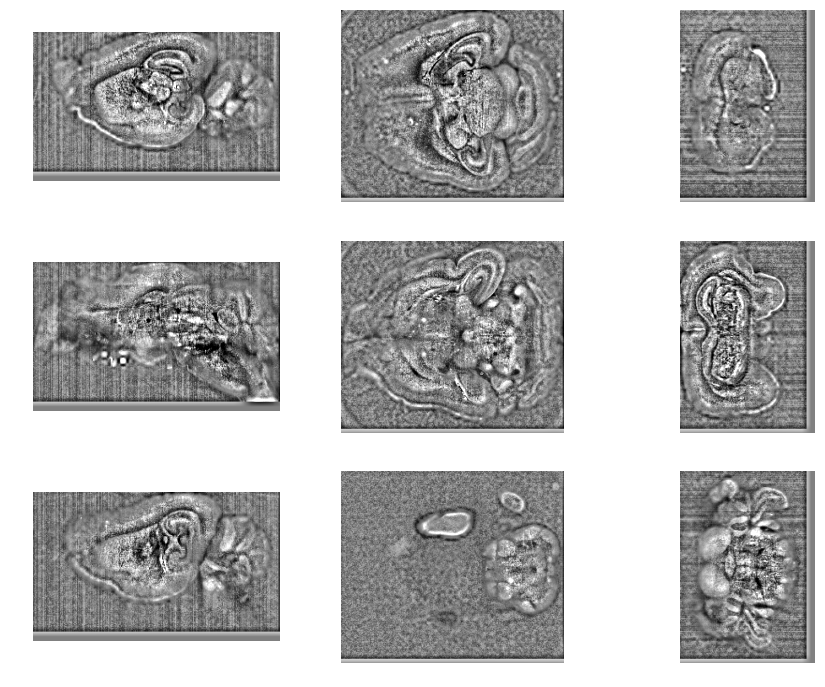

In [24]:
ndreg.imgShow(sitk.Normalize(img_bc_ds_whitened), vmin=-3, vmax=3)

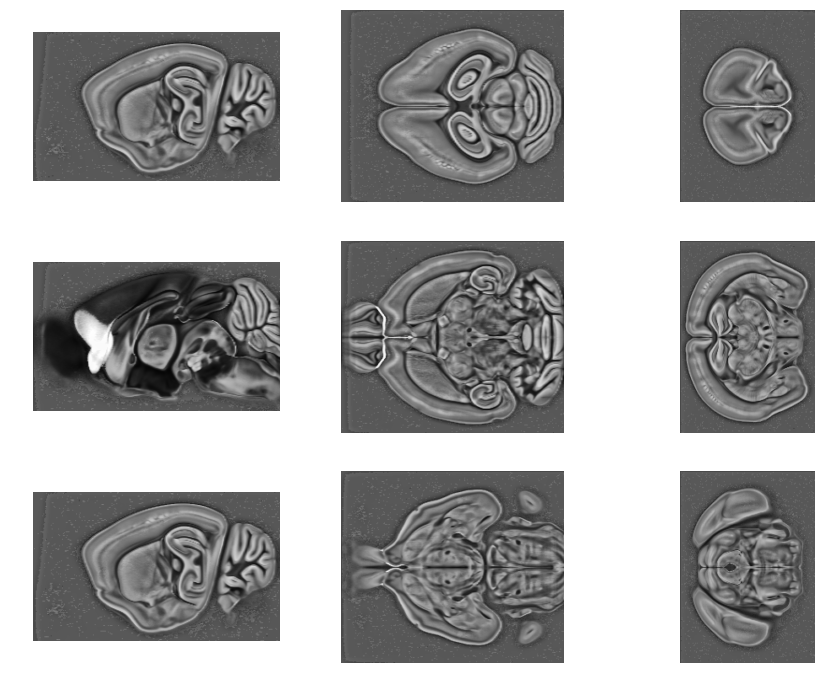

In [25]:
ndreg.imgShow(atlas_ds_whitened)

In [26]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.93291e+07, 883.903, 0, 1.93282e+07 (96.0157%), 3.007813e-05
1.	1.86917e+07, 1185.97, 0, 1.86905e+07 (92.8477%), 3.308594e-05
2.	1.84883e+07, 1278.47, 0, 1.8487e+07 (91.8368%), 9.098633e-06
3.	1.81966e+07, 1414.11, 0, 1.81952e+07 (90.3871%), 1.000850e-05
4.	1.81408e+07, 1607.13, 0, 1.81392e+07 (90.109%), 1.100935e-05
5.	1.78133e+07, 1891.38, 0, 1.78114e+07 (88.4807%), 1.211028e-05
6.	1.77617e+07, 2028.33, 0, 1.77597e+07 (88.2239%), 6.660654e-06
7.	1.77617e+07, 2047.18, 0, 1.77597e+07 (88.2237%), 9.158399e-07
E = 1.77617e+07 (88.2237%)
Length = 76.661
Time = 25.5949s (0.426581m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.52362e+07, 39694.9, 0, 1.51965e+07 (91.6231%), 9.625000e-04
1.	1.43931e+07, 61562, 0, 1.43315e+07 (86.4081%), 1.058750e-03
2.	1.37404e+07, 89543.2, 0, 1.36509e+07 (82.3042%), 1.164625e-03
3.	1.30505e+0

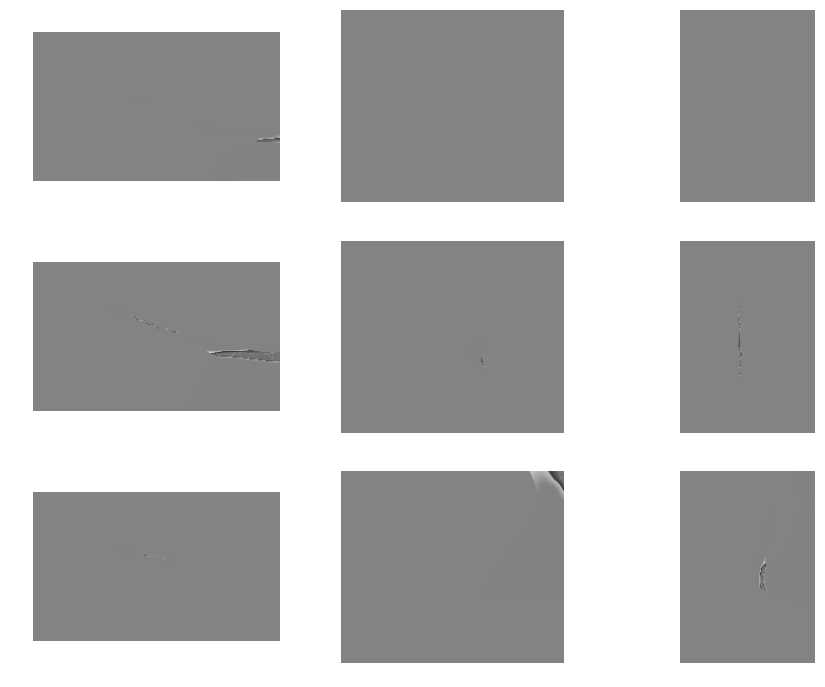

In [27]:
ndreg.imgShow(atlas_lddmm)

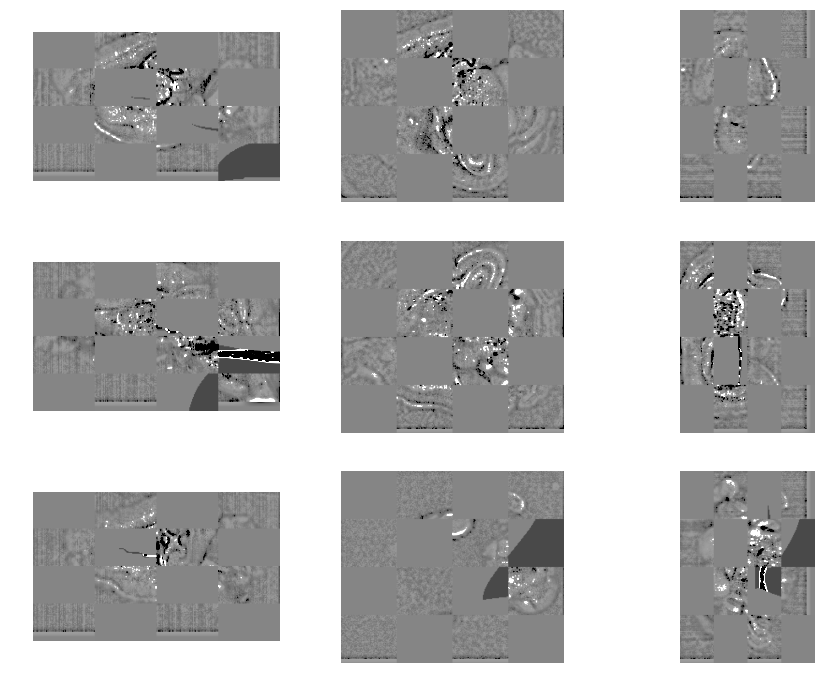

In [28]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)), vmax=1, vmin=-1)

# asdf

In [27]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(out_target_whitened),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.77694e+07, 105402, 0, 1.7664e+07 (96.6405%), 4.812500e-04
1.	1.68233e+07, 162972, 0, 1.66604e+07 (91.1496%), 5.293750e-04
2.	1.68182e+07, 163972, 0, 1.66542e+07 (91.1159%), 1.819727e-05
E = 1.68182e+07 (91.116%)
Length = 549.441
Time = 16.2874s (0.271457m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.39437e+07, 29317.4, 0, 1.39144e+07 (96.1914%), 9.625000e-04
1.	1.30976e+07, 60886.4, 0, 1.30367e+07 (90.124%), 1.058750e-03
2.	1.24741e+07, 101519, 0, 1.23726e+07 (85.5326%), 1.164625e-03
3.	1.19812e+07, 116171, 0, 1.1865e+07 (82.0238%), 1.281088e-03
4.	1.19301e+07, 136774, 0, 1.17933e+07 (81.5279%), 1.409196e-03
5.	1.13722e+07, 155368, 0, 1.12168e+07 (77.5425%), 1.550116e-03
6.	1.1229e+07, 170503, 0, 1.10585e+07 (76.4482%), 1.705127e-03
7.	1.11844e+07, 176480, 0, 1.10079e+07 (76.0985%), 9.378201e-04
8.	1.09796e+07, 195657

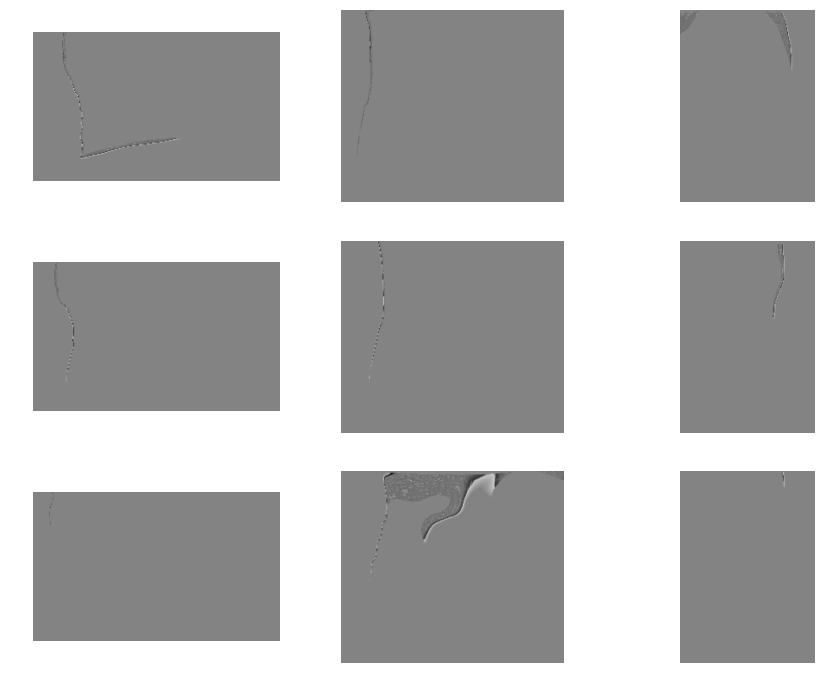

In [28]:
ndreg.imgShow(atlas_lddmm)

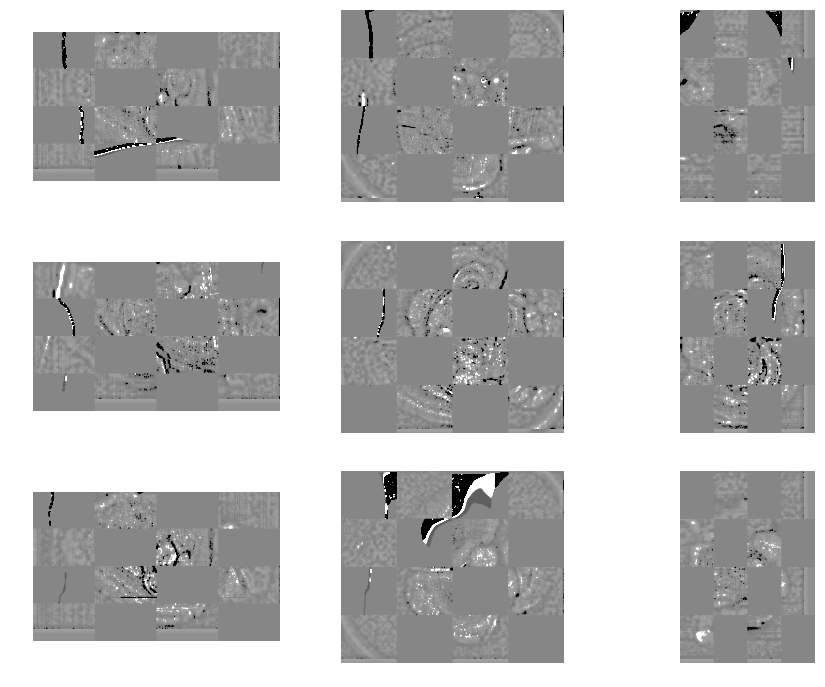

In [29]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)), vmax=1, vmin=-1)